# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

# first five rows of azdias dataframe 
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
# number of rows and columns in azdias dataframe
rows, columns = azdias.shape
print('In azdias dataframe we have:')
print('\u2022 Number of rows:',rows)
print('\u2022 Number of columns:',columns)

In azdias dataframe we have:
• Number of rows: 891221
• Number of columns: 85


In [5]:
# first five rows of feat_info dataframe
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [6]:
feat_info['missing_or_unknown'].unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

In [7]:
rows, columns = feat_info.shape
print('In feat_info dataframe we have:')
print('\u2022 Number of rows:',rows)
print('\u2022 Number of columns:',columns)

In feat_info dataframe we have:
• Number of rows: 85
• Number of columns: 4


In [8]:
# basic information about azdias dataframe
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [9]:
# basic information of feat_info dataframe
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [10]:
# Identify missing or unknown data values and convert them to NaNs.

# first we indentify missing values in azdias datafram originally
# make dataframe to hold missing value counts and percentage
missing_dict = {}
for col in azdias.columns:
    missing_vals = azdias[col].isnull().sum()
    if missing_vals > 0:
        missing_dict[col] = missing_vals
        
# dataframe with missing values 
df_missing = pd.DataFrame(list(missing_dict.items()),columns=['feature','missing_count'])

In [11]:
# calculating percentages for missing values
df_missing['percent_missing'] = (df_missing['missing_count'])/azdias.shape[0]*100
df_missing.sort_values('percent_missing',ascending=False)

,feature,missing_count,percent_missing
15,KK_KUNDENTYP,584612,65.596749
32,KBA05_BAUMAX,133324,14.959701
31,KBA05_ANTG4,133324,14.959701
28,KBA05_ANTG1,133324,14.959701
29,KBA05_ANTG2,133324,14.959701
33,KBA05_GBZ,133324,14.959701
39,MOBI_REGIO,133324,14.959701
30,KBA05_ANTG3,133324,14.959701
38,KKK,121196,13.598872
41,REGIOTYP,121196,13.598872


In [12]:
print('azdias dataframe has:-')
print('\u2022 {} columns as columns with missing values'.format(df_missing.shape[0]))
print('\u2022 making about {}% of all columns with missing values'.format(round((df_missing.shape[0]/azdias.shape[1])*100),2))

azdias dataframe has:-
• 53 columns as columns with missing values
• making about 62% of all columns with missing values


#### As we can see from above:
- `KK_KUNDENTYP` column with most missing values with 65.60% missing.
- 7 columns with around 15% of missing values.
- 34 colums with missing values between 8% and 14% of all values.
- 11 columns with missing values between .5% and 2% of all values.

In [13]:
# using feat_info dataframe to map other missing values in azdias 

#cleaning values in col 'missing_or_unknown'
missing_val_list = feat_info['missing_or_unknown'].str.replace('[','').str.replace(']','').str.lstrip('-').str.split(',')
columns = feat_info['attribute']

# mapping values from feat_info to azdias datafram
#converting thos values to Nan vlaues
for val,col in zip(missing_val_list,columns):
    if val[0] != '':
        for value in val:
            if value.isnumeric():
                value = int(value)
                azdias.loc[azdias[col] == value, col] = np.nan

In [14]:
# makeing dataframe for updated missing values 
# to be compared with earlier missing values
# before mapping values
updated_missing = pd.DataFrame(azdias.isnull().sum(),columns=['missing_count'])
updated_missing.reset_index(inplace=True)
updated_missing.rename({'index':'feature'},axis=1,inplace=True)

In [15]:
updated_missing.sort_values(by='missing_count',ascending=False)

,feature,missing_count
40,TITEL_KZ,891008
21,NATIONALITAET_KZ,792400
64,KBA05_BAUMAX,684941
47,KK_KUNDENTYP,626842
79,PLZ8_BAUMAX,616065
52,GEBAEUDETYP,553613
2,ANREDE_KZ,425916
78,PLZ8_ANTG4,411501
11,GEBURTSJAHR,392318
41,VERS_TYP,381303


**Note:** 

we can see that we have `84` columns in `azdias` dataframe with missing values after we mapped values from `feat_info` dataframe.

**It seems there are changes in missing values in some column. 
Next, we will merge both ``df_missing`` and ``updated_missing`` to 
compare the chages.**

In [16]:
# merging both df_missing and updated_missing
# for easy comparing 

missing_all = df_missing.merge(updated_missing,left_on='feature',right_on='feature',how='outer',suffixes=('_initial','_updated'))
missing_all['percent_missing_updated'] = (missing_all['missing_count_updated'])/azdias.shape[0]*100
missing_all.sort_values(by='percent_missing_updated',ascending=False).head(10)

,feature,missing_count_initial,percent_missing,missing_count_updated,percent_missing_updated
10,TITEL_KZ,73499.0,8.247000,891008,99.976100
66,NATIONALITAET_KZ,NaN,NaN,792400,88.911729
32,KBA05_BAUMAX,133324.0,14.959701,684941,76.854226
15,KK_KUNDENTYP,584612.0,65.596749,626842,70.335192
47,PLZ8_BAUMAX,116515.0,13.073637,616065,69.125952
20,GEBAEUDETYP,93148.0,10.451729,553613,62.118487
55,ANREDE_KZ,NaN,NaN,425916,47.790167
46,PLZ8_ANTG4,116515.0,13.073637,411501,46.172723
63,GEBURTSJAHR,NaN,NaN,392318,44.020282
83,VERS_TYP,NaN,NaN,381303,42.784337


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

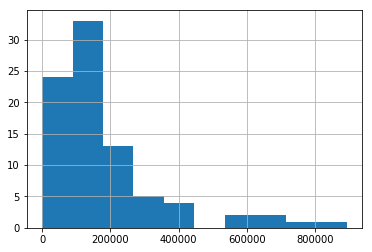

In [17]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

azdias.isnull().sum().hist()

In [18]:
# Investigate patterns in the amount of missing data in each column.
num_col_50 = missing_all.query('percent_missing_updated >50')
num_col_20 = missing_all.query('percent_missing_updated > 20 & percent_missing_updated <50 ')
num_col_less20 = missing_all.query('percent_missing_updated <20')

print('Number of columns with missing values:')
print('\u2022 columns with more then 50%:',num_col_50.shape[0])
print('\u2022 columns with more then 20%:',num_col_20.shape[0])
print('\u2022 colums with less than 20%:', num_col_less20.shape[0])

Number of columns with missing values:
• columns with more then 50%: 6
• columns with more then 20%: 22
• colums with less than 20%: 57


In [19]:
num_col_50['feature'].tolist()

['TITEL_KZ',
 'KK_KUNDENTYP',
 'GEBAEUDETYP',
 'KBA05_BAUMAX',
 'PLZ8_BAUMAX',
 'NATIONALITAET_KZ']

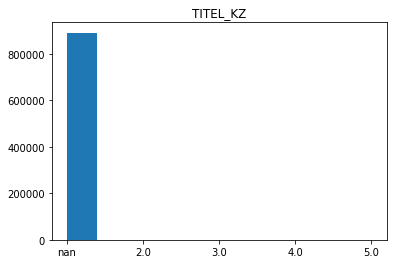

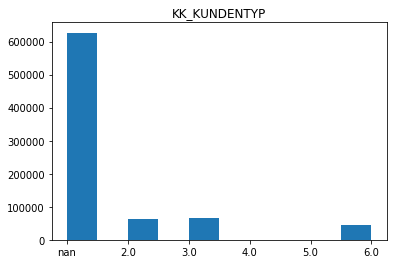

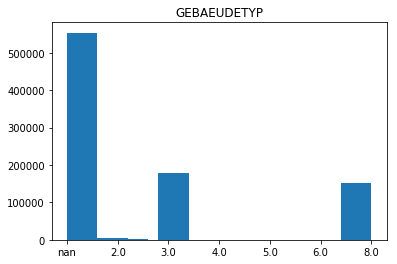

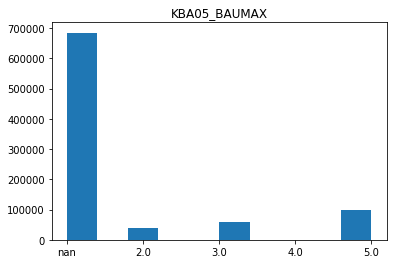

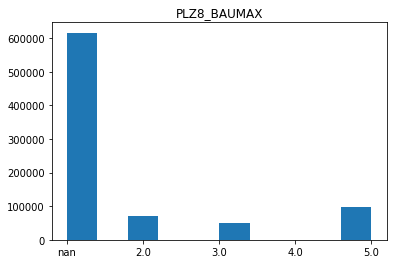

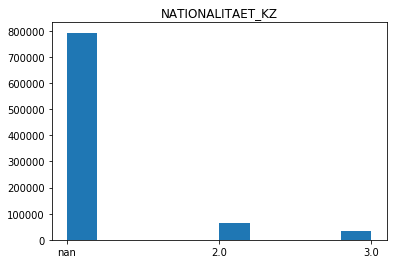

In [20]:
for col in  num_col_50['feature'].tolist():
    plt.hist(azdias[[col]])
    plt.title(col)
    plt.show()

In [21]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
outlier_columns = num_col_50['feature'].tolist()
print('number of columns before drop outliers:',azdias.shape[1])
azdias = azdias.drop(outlier_columns,axis=1)
print('number of columns after drop outliers:',azdias.shape[1])

number of columns before drop outliers: 85
number of columns after drop outliers: 79


#### Discussion 1.1.2: Assess Missing Data in Each Column

In total, we have 85 different columns in our dataset. **84** columns of which have different amount of missing values. 
Those 84 columns with missing values can be divided into 3 groups:

- `6 Columns` with more than **50%** of the values are missing 
- `22 columns` with missing values between **49%** and **20%**.
- `57 columns` with less than **20%** of the values are missing.

We have decided that any column with more than 50% of the values are missing are not useful for further analyses as it might be difficult to investigate what those missing values might be and ways to impute them might be cumbersome.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

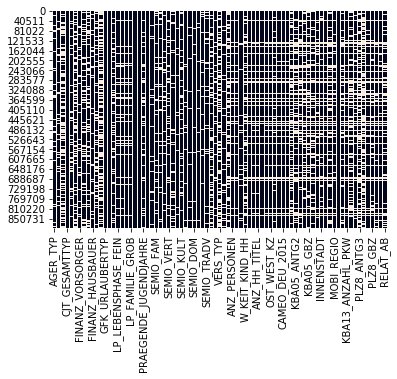

In [22]:
# # plot missing values across columns
sns.heatmap(azdias.isnull(), cbar=False)
plt.show()

**Note: From the plot above, we can see some rows with alot of missing values across last 13 columns in the plot. It will be very helpful to refer back to dataset dictionary.**

A good step is to identify rows with heavy number of missing data and see maximum missing values. 

In [23]:
# How much data is missing in each row of the dataset?
missing_rows = azdias.isnull().sum(axis=1)
missing_rows.sort_values(ascending=False).head()

537799    52
539005    52
15284     52
547468    52
141404    51
dtype: int64

In [24]:
missing_rows.unique()

array([41,  8, 14,  6,  4,  7, 12, 10, 45, 15, 13, 17,  9, 44, 11, 27,  5,
       39, 40,  3, 42, 37, 35, 18, 20, 25, 21, 22, 26, 19, 46,  2, 38, 24,
       16, 34, 36, 23, 43, 29, 30, 49, 33, 31, 28,  1, 47,  0, 52, 51, 32,
       50, 48])

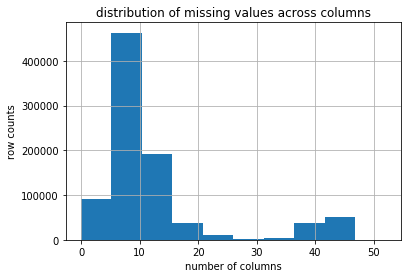

In [25]:
# distribution plot for missing values across columns
missing_rows.hist()
plt.xlabel('number of columns')
plt.ylabel('row counts')
plt.title('distribution of missing values across columns')
plt.show()

In [26]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
missing_above_30 = azdias[azdias.isnull().sum(axis=1) > 30]
missing_below_30 = azdias[azdias.isnull().sum(axis=1) < 30]
few_missing_col = azdias.isnull().sum(axis=0)
few_missing_col = few_missing_col[few_missing_col < 5000].index

In [27]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare(index):
    fig = plt.figure(figsize=(15,4))
    ax1 = fig.add_subplot(1,2,1)
    ax1.title.set_text('rows with more missing')
    sns.countplot(missing_above_30[few_missing_col[index]])
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.title.set_text('rows with few missing')
    sns.countplot(missing_below_30[few_missing_col[index]])
    
    fig.suptitle(few_missing_col[index])
    
    plt.show()

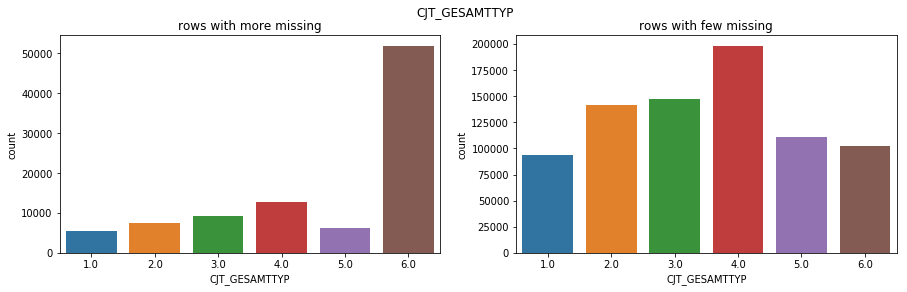

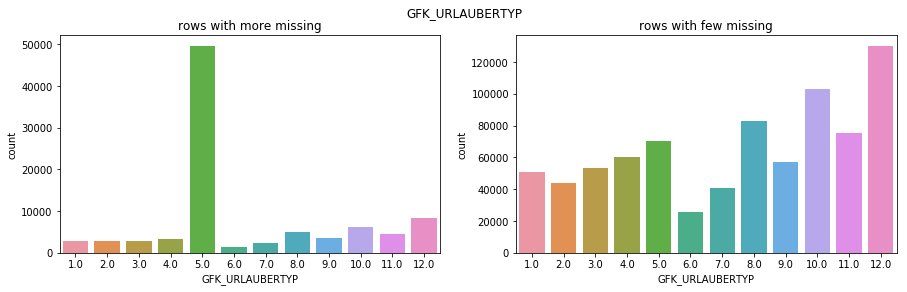

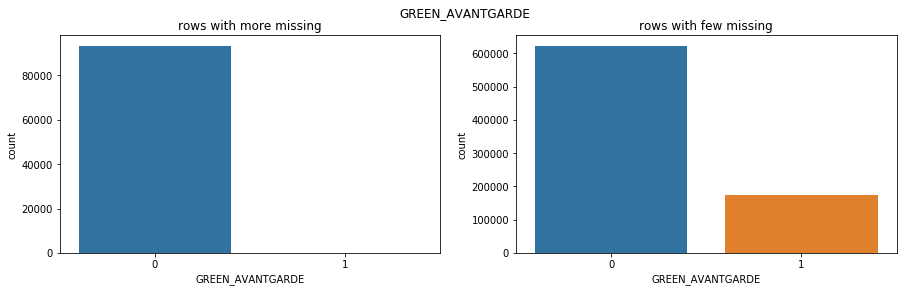

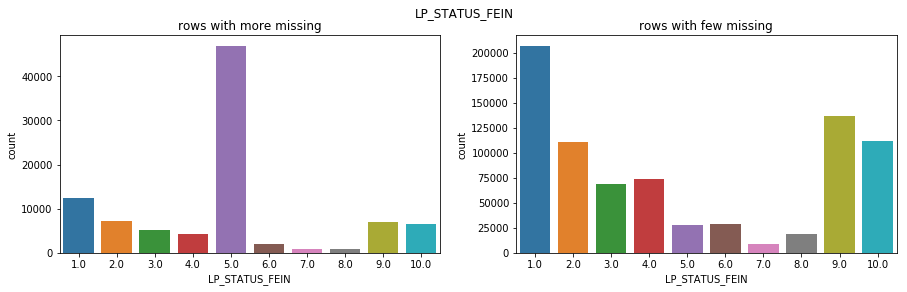

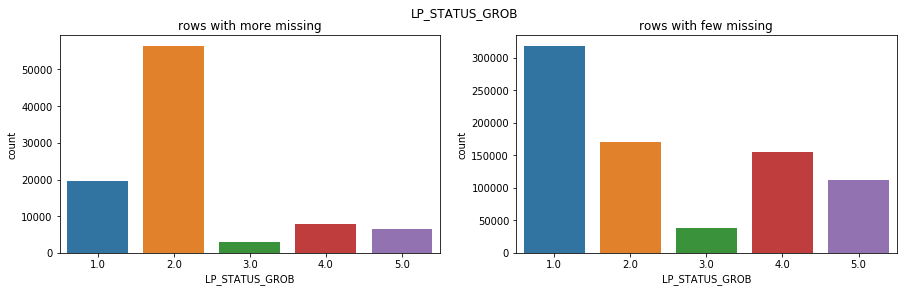

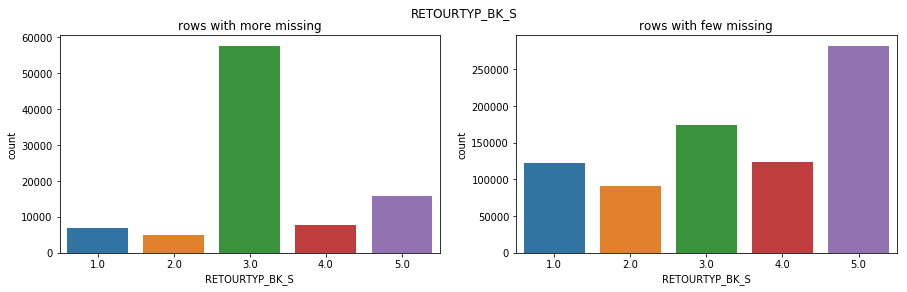

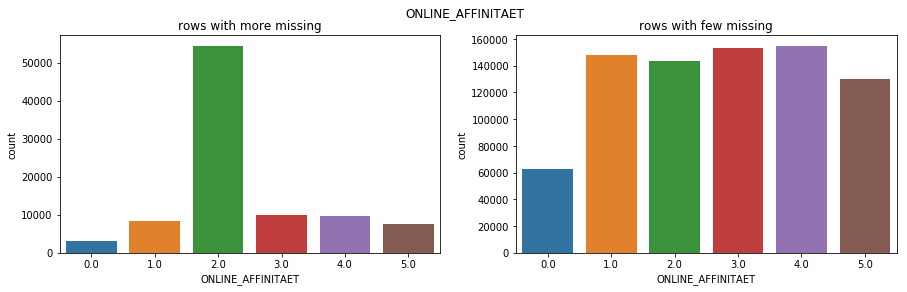

In [28]:
for i in range(len(few_missing_col)):
    compare(i)

In [29]:
azdias_missing = missing_below_30
print('Number of rows:')
print('\u2022 {} before droping rows'.format(azdias.shape[0]))
print('\u2022 {} after dropping rows'.format(azdias_missing.shape[0]))
print('\n number of droped rows:',azdias.shape[0]-azdias_missing.shape[0])

Number of rows:
• 891221 before droping rows
• 797719 after dropping rows

 number of droped rows: 93502


#### Discussion 1.1.3: Assess Missing Data in Each Row

In the beginning of this project, we started with with **891221** number of rows. Examining the rows for missing values we found:
- Around `100,000` rows with missing values between `(0-5)%`.
- Around `500,000` rows with missing values between `(5-10)%`.
- About `200,000` rows with missing values between `(10-15)%`.
- About `60,000` rows with missing values between `(15-30)%`.
- The rest which are less than `100,000` rows are between `(30-52)%`.

Because maximum missing values are across 52 columns and majority of rows have less than 30 missing values, we set **30** missing values as our threshold and divided the dataset to 2 groups. In order to decide if droping those rows will not effect the overall analysis, we compared both groups distributing missing values on columns with few or no missing values and observe of the distribution is consistant. the distribution was the same on `GREEN_AVANTGARDE`,`LP_STATUS_GROB` and `LP_STATUS_GROB`.

We will continue the analysis with the rows of few missing values. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [30]:
# How many features are there of each data type?
feat_info['type'].unique()

array(['categorical', 'ordinal', 'numeric', 'mixed', 'interval'], dtype=object)

**Note:** 
We have 5 different data types in our dataset.

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [31]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_cols = feat_info[feat_info['type']=='categorical']['attribute'].values

multi_level = []
binary_col = []
for col in cat_cols:
    if col in azdias_missing.columns:
        if len(azdias_missing[col].unique()) > 2:
            print('multi-level')
            multi_level.append(col)
        else:
            print('binary')
            binary_col.append(col)
        print(col)
        print(azdias_missing[col].unique())
        print('')

multi-level
AGER_TYP
[ -1.   2.   3.  nan]

binary
ANREDE_KZ
[  2.  nan]

multi-level
CJT_GESAMTTYP
[  5.   3.   2.   4.   1.   6.  nan]

multi-level
FINANZTYP
[ nan   6.   5.   2.   4.   3.]

multi-level
GFK_URLAUBERTYP
[ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.  nan]

binary
GREEN_AVANTGARDE
[0 1]

multi-level
LP_FAMILIE_FEIN
[  5.   1.  nan  10.   2.   7.  11.   8.   4.   6.   9.   3.]

multi-level
LP_FAMILIE_GROB
[  3.   1.  nan   5.   2.   4.]

multi-level
LP_STATUS_FEIN
[  2.   3.   9.   4.   1.  10.   5.   8.   6.   7.  nan]

multi-level
LP_STATUS_GROB
[  1.   2.   4.   5.   3.  nan]

multi-level
SHOPPER_TYP
[  3.   2.  nan   0.  -1.]

binary
SOHO_KZ
[ nan   0.]

multi-level
VERS_TYP
[  2.  nan  -1.]

multi-level
ZABEOTYP
[  5.   3.   4.  nan   6.   2.]

binary
OST_WEST_KZ
['W' 'O']

multi-level
CAMEO_DEUG_2015
['8' '4' '2' '6' '1' '9' '5' '7' nan '3' 'X']

multi-level
CAMEO_DEU_2015
['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D' '9E'
 n

In [32]:
print(multi_level)
print('')
print(binary_col)

['AGER_TYP', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']


- For column `OST_WEST_KZ`, we will re-encode non-numeric values to numeric values.
- For multi-level columns `('AGER_TYP', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015')` we will re-encode using `pd.get_dummies`.

In [33]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_missing['ANREDE_KZ'].replace(2.0,1,inplace=True)
azdias_missing['OST_WEST_KZ'].replace('W',0,inplace=True)
azdias_missing['OST_WEST_KZ'].replace('O',1,inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [34]:
azdias_missing = pd.get_dummies(azdias_missing,columns=multi_level)

print('number of columns after transformation:',azdias_missing.shape[0])

number of columns after transformation: 797719


#### Discussion 1.2.1: Re-Encode Categorical Features

Looking on feat_info dataset, we have found five different data types
('categorical', 'ordinal', 'numeric', 'mixed', 'interval').

Then we moved to `categorical` columns which divides to two groups:
- `Binary` categorical columns.
- `Multi-level` categorical columns. 

For both groups we had to re-encode the values such that string values are converted to numerical as in column `OST_WEST_KZ`.
For multi-level columns, we used `pd.get_dummies` to encode string values to numerical.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [35]:
azdias_missing['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    182935
8.0     141567
10.0     85793
5.0      84670
3.0      53827
15.0     42516
11.0     35740
9.0      33567
6.0      25651
12.0     24445
4.0      20446
2.0       7478
13.0      5762
7.0       4009
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [36]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# movement feature
azdias_missing['PRAEGENDE_JUGENDJAHRE_movement'] = azdias_missing['PRAEGENDE_JUGENDJAHRE'].copy()

azdias_missing.loc[azdias_missing['PRAEGENDE_JUGENDJAHRE_movement'].isin([1,3,5,8,14,10,12]),
                   'PRAEGENDE_JUGENDJAHRE_movement'] = 0

azdias_missing.loc[azdias_missing['PRAEGENDE_JUGENDJAHRE_movement'].isin([2,4,9,15,6,11,7,13]),
                   'PRAEGENDE_JUGENDJAHRE_movement'] = 1

In [37]:
# generation feature
azdias_missing['PRAEGENDE_JUGENDJAHRE_generation'] = azdias_missing['PRAEGENDE_JUGENDJAHRE'].copy()

azdias_missing.loc[azdias_missing['PRAEGENDE_JUGENDJAHRE_generation'].isin([1,2]),
                  'PRAEGENDE_JUGENDJAHRE_generation'] = 0

azdias_missing.loc[azdias_missing['PRAEGENDE_JUGENDJAHRE_generation'].isin([3,4]),
                  'PRAEGENDE_JUGENDJAHRE_generation'] = 1

azdias_missing.loc[azdias_missing['PRAEGENDE_JUGENDJAHRE_generation'].isin([5,6,7]),
                  'PRAEGENDE_JUGENDJAHRE_generation'] = 2

azdias_missing.loc[azdias_missing['PRAEGENDE_JUGENDJAHRE_generation'].isin([8,9]),
                  'PRAEGENDE_JUGENDJAHRE_generation'] = 3

azdias_missing.loc[azdias_missing['PRAEGENDE_JUGENDJAHRE_generation'].isin([10,11,12,13]),
                  'PRAEGENDE_JUGENDJAHRE_generation'] = 4

azdias_missing.loc[azdias_missing['PRAEGENDE_JUGENDJAHRE_generation'].isin([14,15]),
                  'PRAEGENDE_JUGENDJAHRE_generation'] = 5

In [38]:
# nation feature 
azdias_missing['PRAEGENDE_JUGENDJAHRE_nation'] = azdias_missing['PRAEGENDE_JUGENDJAHRE'].copy()

azdias_missing.loc[azdias_missing['PRAEGENDE_JUGENDJAHRE_nation'].isin([1,2,3,4,5,8,9,14,15]),
          'PRAEGENDE_JUGENDJAHRE_nation'] = 0

azdias_missing.loc[azdias_missing['PRAEGENDE_JUGENDJAHRE_nation'].isin([6,10,11]),
          'PRAEGENDE_JUGENDJAHRE_nation'] = 1

azdias_missing.loc[azdias_missing['PRAEGENDE_JUGENDJAHRE_nation'].isin([7,12,13]),
          'PRAEGENDE_JUGENDJAHRE_nation'] = 2

In [39]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
print(azdias_missing['CAMEO_INTL_2015'].dtype)
azdias_missing['CAMEO_INTL_2015'].unique()

object


array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41',
       '34', '55', nan, '25', '23', '31', '52', '35', '45', '44', '32',
       'XX'], dtype=object)

In [40]:
azdias_missing.loc[azdias_missing['CAMEO_INTL_2015']=='XX','CAMEO_INTL_2015'] = np.nan

azdias_missing['CAMEO_INTL_2015_wealth'] = pd.to_numeric(azdias_missing['CAMEO_INTL_2015'].str[0])
azdias_missing['CAMEO_INTL_2015_life_stage'] = pd.to_numeric(azdias_missing['CAMEO_INTL_2015'].str[1])

print(azdias_missing['CAMEO_INTL_2015_wealth'].value_counts())
print(azdias_missing['CAMEO_INTL_2015_life_stage'].value_counts())

5.0    223568
2.0    190613
4.0    189944
1.0    119409
3.0     68165
Name: CAMEO_INTL_2015_wealth, dtype: int64
1.0    245031
4.0    232724
3.0    119640
5.0    117024
2.0     77280
Name: CAMEO_INTL_2015_life_stage, dtype: int64


#### Discussion 1.2.2: Engineer Mixed-Type Features

In this part, we worked with columns that contains mixed-type values with different levels. 

For column `PRAEGENDE_JUGENDJAHRE`, we had three different informations:
- **Movement**: 
     - 0 for MainStream
     - 1 for avantgarde
- **Generation**:
     - 0 for 40s
     - 1 for 50s
     - 2 for 60s
     - 3 for 70s
     - 4 for 80s
     - 5 for 90s
- **Nation**
     - 0 for E+W
     - 1 for W
     - 2 for E
 
 For column `CAMEO_INTL_2015`, we had two levels of information:
 - **Wealth**
 - **Life_stage**

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [41]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

azdias_missing.drop('PRAEGENDE_JUGENDJAHRE',axis=1,inplace=True)
azdias_missing.dtypes.value_counts()

uint8      123
float64     67
int64        2
object       1
dtype: int64

In [42]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

azdias_missing.drop('CAMEO_INTL_2015',axis=1,inplace=True)
azdias_missing.dtypes.value_counts()

uint8      123
float64     67
int64        2
dtype: int64

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [43]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    missing_val_list = feat_info['missing_or_unknown'].str.replace('[','').str.replace(']','').str.lstrip('-').str.split(',')
    columns = feat_info['attribute']

    # mapping values from feat_info to azdias datafram
    #converting thos values to Nan vlaues
    for val,col in zip(missing_val_list,columns):
        if val[0] != '':
            for value in val:
                if value.isnumeric():
                    value = int(value)
                    df.loc[df[col] == value, col] = np.nan
    
    # remove selected columns and rows, ...
    df = df.drop(outlier_columns,axis=1)
    
    missing_below_30 = df[df.isnull().sum(axis=1) < 30]
    df = missing_below_30
    df_missing_more = df[df.isnull().sum(axis=1) > 30]
    
    # select, re-encode, and engineer column values.
    df['ANREDE_KZ'] = df['ANREDE_KZ'].replace(2.0,1)
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace('W',0)
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace('O',1)
    df = pd.get_dummies(df,columns=multi_level)
    
    df['PRAEGENDE_JUGENDJAHRE_movement'] = df['PRAEGENDE_JUGENDJAHRE'].copy()
    df.loc[df['PRAEGENDE_JUGENDJAHRE_movement'].isin([1,3,5,8,14,10,12]),
           'PRAEGENDE_JUGENDJAHRE_movement'] = 0

    df.loc[df['PRAEGENDE_JUGENDJAHRE_movement'].isin([2,4,9,15,6,11,7,13]),
           'PRAEGENDE_JUGENDJAHRE_movement'] = 1
    
    df['PRAEGENDE_JUGENDJAHRE_generation'] = df['PRAEGENDE_JUGENDJAHRE'].copy()
    df.loc[df['PRAEGENDE_JUGENDJAHRE_generation'].isin([1,2]),
           'PRAEGENDE_JUGENDJAHRE_generation'] = 0

    df.loc[df['PRAEGENDE_JUGENDJAHRE_generation'].isin([3,4]),
           'PRAEGENDE_JUGENDJAHRE_generation'] = 1

    df.loc[df['PRAEGENDE_JUGENDJAHRE_generation'].isin([5,6,7]),
           'PRAEGENDE_JUGENDJAHRE_generation'] = 2

    df.loc[df['PRAEGENDE_JUGENDJAHRE_generation'].isin([8,9]),
           'PRAEGENDE_JUGENDJAHRE_generation'] = 3

    df.loc[df['PRAEGENDE_JUGENDJAHRE_generation'].isin([10,11,12,13]),
           'PRAEGENDE_JUGENDJAHRE_generation'] = 4

    df.loc[df['PRAEGENDE_JUGENDJAHRE_generation'].isin([14,15]),
           'PRAEGENDE_JUGENDJAHRE_generation'] = 5
    
    df['PRAEGENDE_JUGENDJAHRE_nation'] = df['PRAEGENDE_JUGENDJAHRE'].copy()
    df.loc[df['PRAEGENDE_JUGENDJAHRE_nation'].isin([1,2,3,4,5,8,9,14,15]),
           'PRAEGENDE_JUGENDJAHRE_nation'] = 0

    df.loc[df['PRAEGENDE_JUGENDJAHRE_nation'].isin([6,10,11]),
           'PRAEGENDE_JUGENDJAHRE_nation'] = 1

    df.loc[df['PRAEGENDE_JUGENDJAHRE_nation'].isin([7,12,13]),
           'PRAEGENDE_JUGENDJAHRE_nation'] = 2
    
    df.loc[df['CAMEO_INTL_2015']=='XX','CAMEO_INTL_2015'] = np.nan

    df['CAMEO_INTL_2015_wealth'] = pd.to_numeric(df['CAMEO_INTL_2015'].str[0])
    df['CAMEO_INTL_2015_life_stage'] = pd.to_numeric(df['CAMEO_INTL_2015'].str[1])
    
    df.drop('PRAEGENDE_JUGENDJAHRE',axis=1,inplace=True)
    df.drop('CAMEO_INTL_2015',axis=1,inplace=True)

    
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [44]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
imputed_missing = azdias_missing.copy()
imputer = Imputer(missing_values=np.nan,strategy='median')
azdias_imputed = imputer.fit_transform(imputed_missing)

In [45]:
# Apply feature scaling to the general population demographics data
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_imputed)

In [46]:
# shape after scale transformation
azdias_scaled.shape

(797719, 192)

### Discussion 2.1: Apply Feature Scaling

For this part, we have imputed remaining missing values with `median` as it provides a better handling orginal distribution of the data. After that we have scaled the features in our dataset using `StandardScaler` so that we get:
- mean = 0
- standard_deviation = 1

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [47]:
# Apply PCA to the data.
# n_components = half num_features.

pca = PCA(azdias_scaled.shape[1]//2)
azdias_pca = pca.fit_transform(azdias_scaled)

In [48]:
# Investigate the variance accounted for by each principal component.
# referance: udacity unsupervised-learning class helper file

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
    print('array shows percent of variance explained for each principal component')
    print(np.round(vals,2))

array shows percent of variance explained for each principal component
[ 0.07  0.05  0.03  0.03  0.02  0.02  0.02  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.    0.    0.    0.    0.    0.    0.  ]


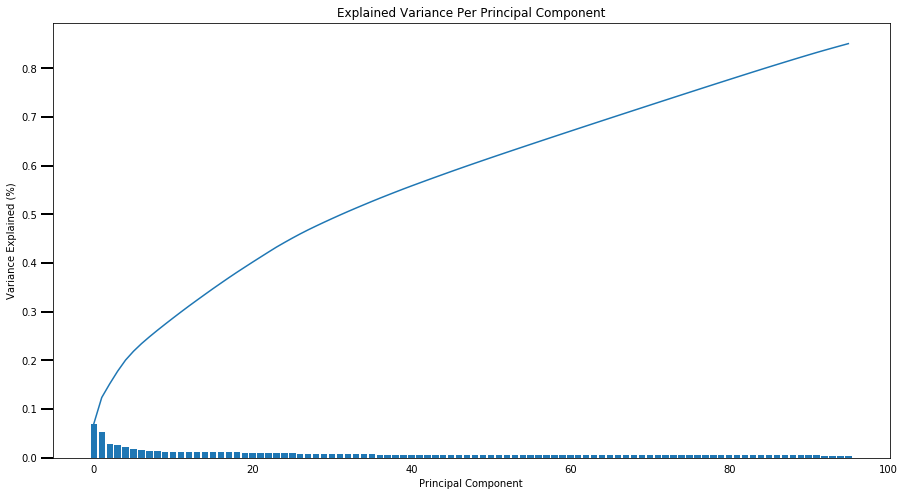

In [49]:
scree_plot(pca)

array shows percent of variance explained for each principal component
[ 0.07  0.05  0.03  0.03  0.02  0.02  0.02  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]


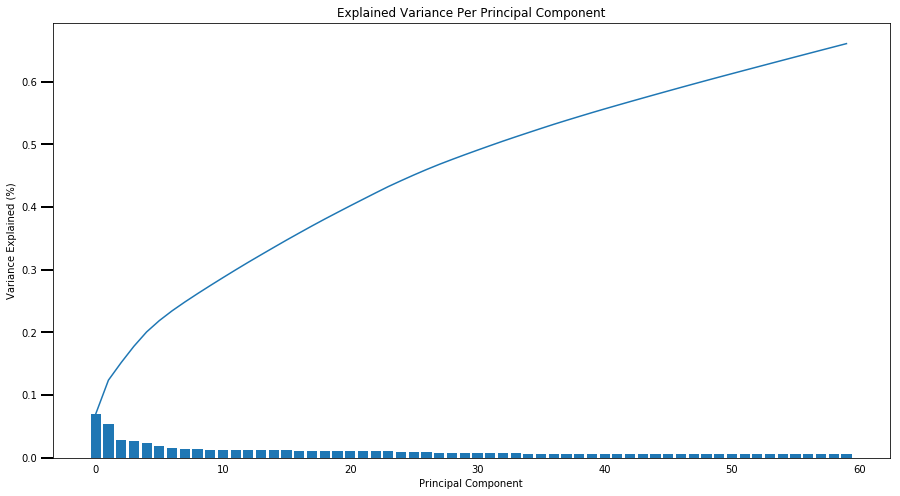

In [50]:
# Re-apply PCA to the data while selecting 60 for number of components to retain.
pca = PCA(60)
azdias_pca = pca.fit_transform(azdias_scaled)

scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

At first, we started by choosing a number of components equal to half of our feature in dataset. First component had a variance explained of about 7% and the following about 5% while the rest had around 1%. In total, they explained about 90% of all variance in our data. Hence a good choice would be having 60 principal components where they explain about 70% of all variance in our dataset. We have reduced number of diminsions from 192 to 60 and is a better number of features for performance and for interpretibility as well. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [51]:
# reference: helper function from udacity class unsupervised_learning PCA
def pca_results(data, pca, num_comp):
    '''
    Create a DataFrame of the PCA results
    Includes component feature weights
    '''
    # PCA components wanted
    num_comp = num_comp-1
    
    df_component = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys())
    pca_comp = df_component.iloc[num_comp]
    pca_comp.sort_values(ascending=False,inplace=True)
    
    top_three = pca_comp.head(3)
    bottom_three = pca_comp.tail(3)
    
    return top_three,bottom_three

In [52]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
component_1_top,component_1_bottom = pca_results(azdias_missing,pca,1)
print('Positive PCA components weights\n')
print(component_1_top)
print('>-----------------------------------<')
print('Negative PCA components weights\n')
print(component_1_bottom)

Positive PCA components weights

LP_STATUS_GROB_1.0        0.2090
CAMEO_INTL_2015_wealth    0.1976
HH_EINKOMMEN_SCORE        0.1778
Name: 0, dtype: float64
>-----------------------------------<
Negative PCA components weights

FINANZ_MINIMALIST   -0.1895
KBA05_ANTG1         -0.1974
MOBI_REGIO          -0.2144
Name: 0, dtype: float64


In [53]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
component_2_top,component_2_bottom = pca_results(azdias_missing,pca,2)

print('Positive PCA components weights\n')
print(component_2_top)
print('>-----------------------------------<')
print('Negative PCA components weights\n')
print(component_2_bottom)

Positive PCA components weights

FINANZ_VORSORGER    0.2086
ZABEOTYP_3.0        0.2024
SEMIO_LUST          0.1975
Name: 1, dtype: float64
>-----------------------------------<
Negative PCA components weights

ALTER_HH                           -0.2069
GEBURTSJAHR                        -0.2113
PRAEGENDE_JUGENDJAHRE_generation   -0.2399
Name: 1, dtype: float64


In [54]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

component_3_top,component_3_bottom = pca_results(azdias_missing,pca,3)

print('Positive PCA components weights\n')
print(component_3_top)
print('>-----------------------------------<')
print('Negative PCA components weights\n')
print(component_3_bottom)

Positive PCA components weights

LP_LEBENSPHASE_GROB    0.2728
LP_LEBENSPHASE_FEIN    0.2639
LP_FAMILIE_GROB_5.0    0.2559
Name: 2, dtype: float64
>-----------------------------------<
Negative PCA components weights

INNENSTADT            -0.1561
LP_FAMILIE_FEIN_1.0   -0.2525
LP_FAMILIE_GROB_1.0   -0.2525
Name: 2, dtype: float64


### Discussion 2.3: Interpret Principal Components

Investigating features associated with some pricipal components, there are number of findings:
- PCA 1:
    - Positive weights:
        - LP_STATUS_GROB_1.0: Social status
        - CAMEO_INTL_2015_wealth: Household wealth
        - HH_EINKOMMEN_SCORE: Estimated household net income
    - Negative weights:
        - FINANZ_MINIMALIST: Financial topology, low financial interest
        - KBA05_ANTG1: Number of 1-2 family houses in the microcell
        - MOBI_REGIO: Movement patterns
        
Component 1 seems to focuses on social status, income level and resulting financing and movement. 
        
- PCA 2:
    - Positive weights:
        - FINANZ_VORSORGER: finacially be prepared
        - ZABEOTYP_3.0: Energy consumption typology, fairly supplied
        - SEMIO_LUST: Personality typology, sensual-minded
    - Negative weights:
        - ALTER_HH: Birthdate of head of household
        - GEBURTSJAHR: Year of birth
        - PRAEGENDE_JUGENDJAHRE_generation: Dominating movement of person's youth (generation)
        
Component 2 is related to financial status, age and personality.

- PCA 3:
    - Positive weights:
        - LP_LEBENSPHASE_GROB: Life stage, rough scale
        - LP_LEBENSPHASE_FEIN: Life stage, fine scale
        - LP_FAMILIE_GROB_5.0: Family type, rough scale, multi-household
    - Negative weights:
        - INNENSTADT: Distance to city center (downtown)
        - LP_FAMILIE_FEIN_1.0: Family type, fine scale, single
        - LP_FAMILIE_GROB_1.0: Family type, rough scale, single
        
Component 3 is related to persons status and its relation to number and location of housing.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [55]:
# Over a number of different cluster counts...

def kmeans_scores(data, centers):
    
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=centers)

    model = kmeans.fit(data)
    
    # compute the average within-cluster distances.
    score = np.abs(model.score(data))
    
    return score

In [56]:
sample_idx = azdias_pca[np.random.choice(azdias_pca.shape[0],int(azdias_pca.shape[0]*0.1),replace=False)]
sample_idx.shape

(79771, 60)

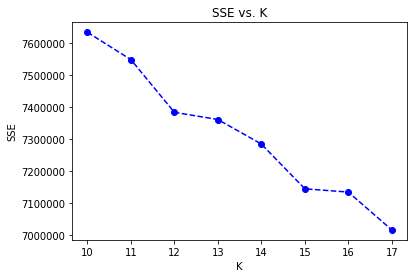

In [57]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

scores = []
centers = list(range(10,18))

for center in centers:
    scores.append(kmeans_scores(sample_idx, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

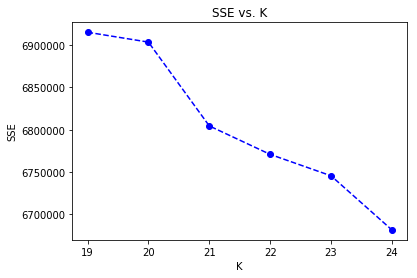

In [58]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

scores = []
centers = list(range(19,25))

for center in centers:
    scores.append(kmeans_scores(sample_idx, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [59]:
kmeans = KMeans(23)
model = kmeans.fit(azdias_pca)
azdias_kmean = model.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population
First, we worked with a random sample of dataset to speed up the learning process. Then we started learning process with 10 centers and moved to 25 clusters. By scree ploting (centers) and the sum squered distances (sse) for each number of clusters, we were to better evaluate the preformance for different clusters. 


We choosed to work with 23 clusters. though, the 23 clusters seems applicable beacuse sum of squered distances didn't change much after 23 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [60]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')
customers_clean = clean_data(customers)

In [61]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_imputed = imputer.transform(customers_clean)
customers_scaled = scaler.transform(customers_imputed)
customers_pca = pca.transform(customers_scaled)

customers_kmean = model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [62]:
customers_missing = customers[customers.isnull().sum(axis=1)>30]
azdias_missing = missing_above_30

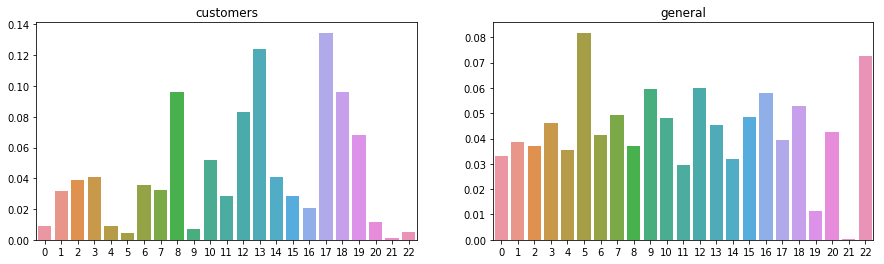

In [63]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

customer_proportions = pd.Series(customers_kmean).value_counts(normalize=True)
general_proportions = pd.Series(azdias_kmean).value_counts(normalize=True)

fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(1,2,1)
ax1.title.set_text('customers')
sns.barplot(customer_proportions.index,customer_proportions.values)

ax2 = fig.add_subplot(1,2,2)
ax2.title.set_text('general')
sns.barplot(general_proportions.index,general_proportions.values)

In [64]:

for x in range(0,23):
    customer_score = customer_proportions[x]
    general_score = general_proportions[x]
    if_target = general_score-customer_score
    print(x)
    print('customers:',customer_score,'   ','general:',general_score)
    if if_target < 0 :
        print('off target')
        print('the difference:',if_target )
    else:
        print('target group')
        print('the difference:', if_target)
    print('')

0
customers: 0.00926311627611     general: 0.0330943602948
target group
the difference: 0.0238312440187

1
customers: 0.0314042234727     general: 0.0387304301389
target group
the difference: 0.00732620666625

2
customers: 0.0388881436348     general: 0.0370706978272
off target
the difference: -0.0018174458076

3
customers: 0.0407944251855     general: 0.0462431006407
target group
the difference: 0.00544867545519

4
customers: 0.00909366902716     general: 0.0355087443072
target group
the difference: 0.02641507528

5
customers: 0.00470922146049     general: 0.0818245522546
target group
the difference: 0.0771153307941

6
customers: 0.035541560468     general: 0.041212507161
target group
the difference: 0.00567094669309

7
customers: 0.0325974145174     general: 0.0495023937
target group
the difference: 0.0169049791826

8
customers: 0.0962813389157     general: 0.0368977045802
off target
the difference: -0.0593836343355

9
customers: 0.00725093019479     general: 0.0595347484515
target g

In [65]:
# pca features for 3 components
component_1 = ['LP_STATUS_GROB_1.0','CAMEO_INTL_2015_wealth','HH_EINKOMMEN_SCORE',
                  'FINANZ_MINIMALIST','KBA05_ANTG1','MOBI_REGIO']

component_2 = ['FINANZ_VORSORGER','ZABEOTYP_3.0','SEMIO_LUST',
                   'ALTER_HH','GEBURTSJAHR','PRAEGENDE_JUGENDJAHRE_generation']

component_3 = ['LP_LEBENSPHASE_GROB','LP_LEBENSPHASE_FEIN','LP_FAMILIE_GROB_5.0',
                   'INNENSTADT','LP_FAMILIE_FEIN_1.0','LP_FAMILIE_GROB_1.0']

In [66]:
# recovering general population dataset from pca 
back_pca = pca.inverse_transform(azdias_pca)
back_general = scaler.inverse_transform(back_pca)
general_population = pd.DataFrame(np.round(back_general),columns=imputed_missing.columns)
general_population['clusters'] = azdias_kmean

In [67]:
# ploting function for recoverd dataset 
# and specified clusters

def cluster_plot(col,k):

    cluster_k = general_population[general_population['clusters']==k]
    
    fig,ax = plt.subplots(2,3, figsize=(20,10))

    sns.countplot(cluster_k[col[0]],ax=ax[0,0])
    
    sns.countplot(cluster_k[col[1]],ax=ax[0,1])

    sns.countplot(cluster_k[col[2]],ax=ax[0,2])
    
    sns.countplot(cluster_k[col[3]],ax=ax[1,0])

    sns.countplot(cluster_k[col[4]],ax=ax[1,1])
    
    sns.countplot(cluster_k[col[5]],ax=ax[1,2])
    
    
    plt.show()

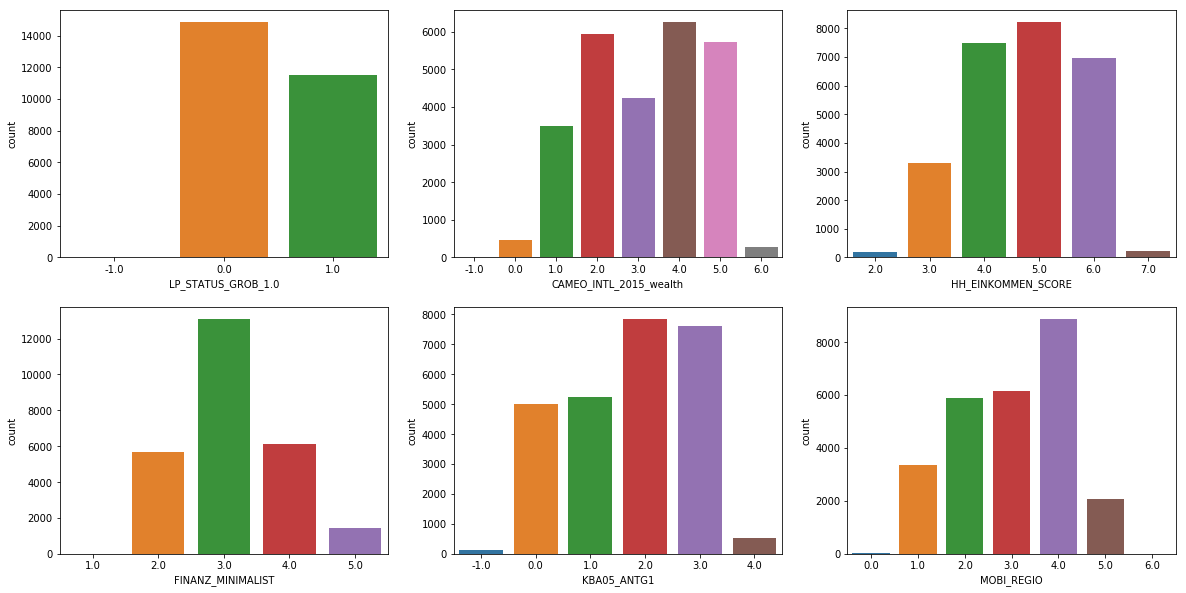

In [68]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
    
# cluster number 4 for pca number 1
cluster_plot(component_1,0)

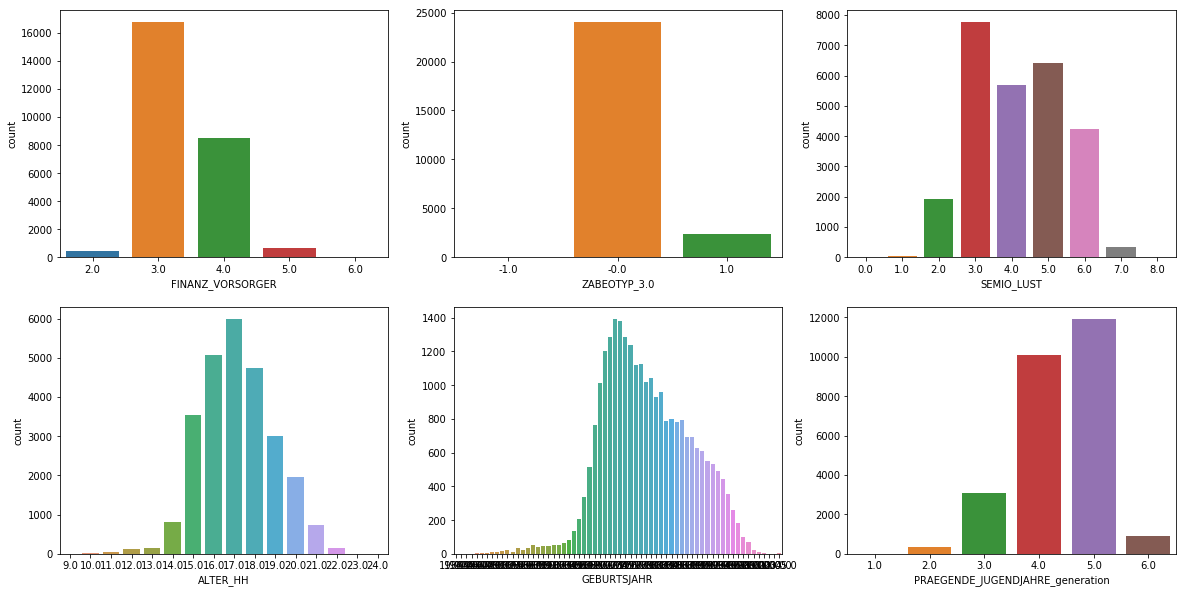

In [69]:
# cluster number 4 for pca number 2
cluster_plot(component_2,0)

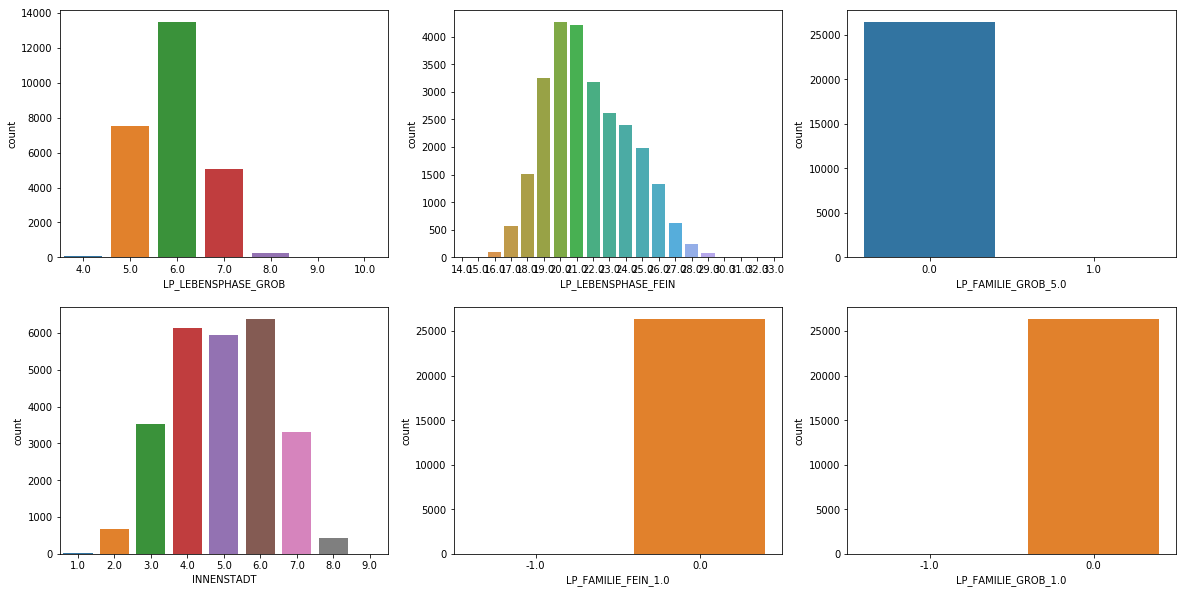

In [70]:
# cluster number 4 for pca number 3
cluster_plot(component_3,0)

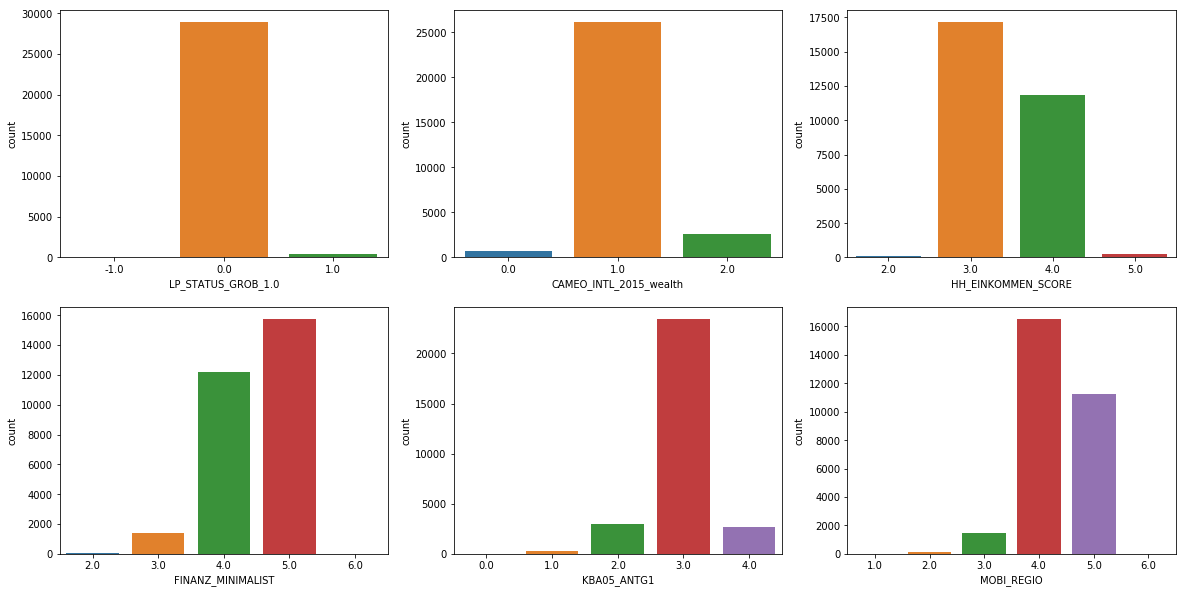

In [77]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# cluster number 8 for pca number 1
cluster_plot(component_1,8)

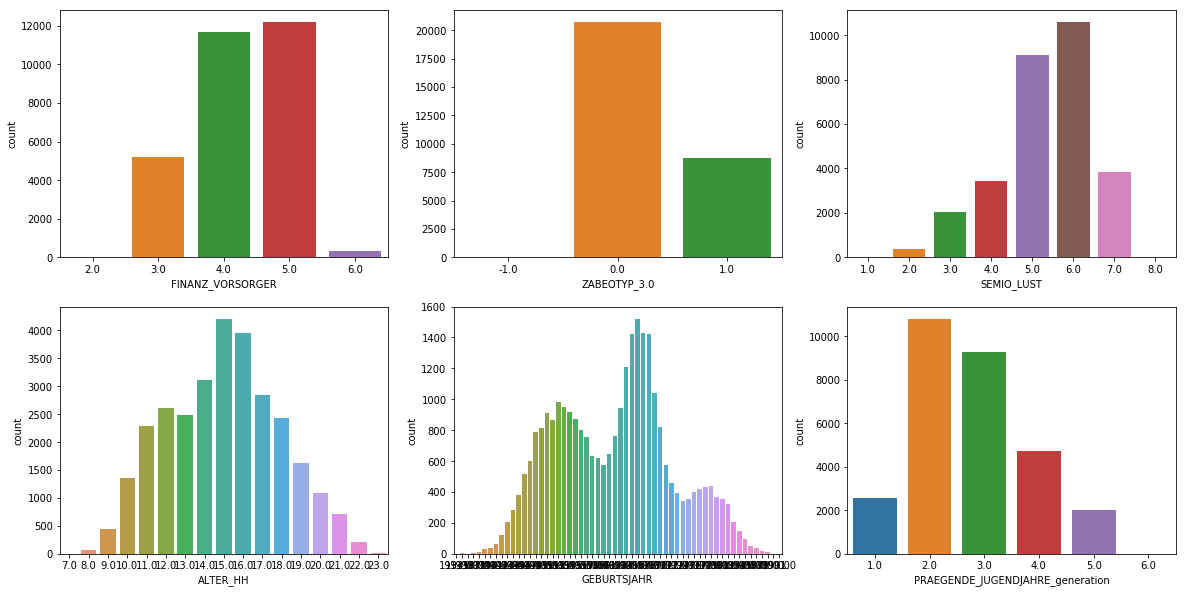

In [78]:
# cluster number 8 for pca number 2
cluster_plot(component_2,8)

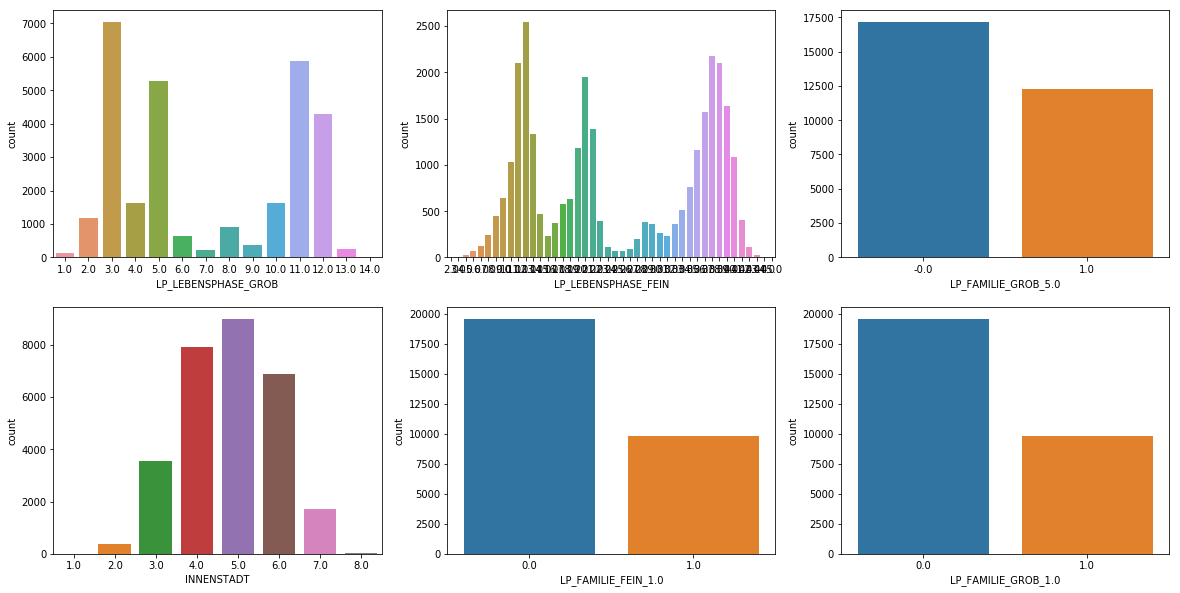

In [79]:
# cluster number 8 for pca number 3
cluster_plot(component_3,8)

### Discussion 3.3: Compare Customer Data to Demographics Data

Through this analysis, we found that in terms of general population, middle class and lower families and indivisuals can be target future customers for the company. As customer dataset showed that the company is well established among upper-middle class families and indivisuals who live a bit far from city-centers and with few movement. For age, persons of almost ages of  50-60 are some potential customers as found from general population clusters that are similer to customer clusters. 

There are some differences between the clusters obtained for customer dataset and for the general population. 

For the population groups that should focused on for targeted adds: 
- For group of people in pca component 1 in cluster 0. 
    - we can see that the population can be described as low middle class families of different span of ages with 1-2 houses and have high movement pattern. This group is with high potential to be future customers. Customer dataset for cluster 4 didn't capture this information which indicates the dataset didn't capture this group of demographic.
    
- For group of people in pca component 2 in cluster 0
    - we can see that the population can be described as lower financial standing, low sensual personality, born between 1940s to 1970s and raised in those years. This group is with high potential to be future customers. Customer dataset for cluster 4 didn't capture this information which indicates the dataset didn't capture this group of demographic.
    
- For group of people in pca component 3 in cluster 0
     - we can see that the population can be described as low income aged indivisiuals, single midle aged average earner to old home owner, 5-15km from city-center and singles as whole. This group is with high potential to be future customers. Customer dataset for cluster 0 didn't capture this information which indicates the dataset didn't capture this group of demographic.
     
In conclusion, comparing different clusters where general population dataset were underrepresented using grouped features by pca components showed there are potential benefets to futher analyes other groupings where underrepresentation is present. We have showed how a segment of people with similar characteristics can help distiguish possible future customers. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.